In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import pyvisa as visa
import pickle
from tqdm import tqdm
from mcculw import ul

In [3]:
np.set_printoptions(threshold=8)

def set_osc_acq(osc):
    # Configuración de la adquisición de curvas
    osc.write('DAT:ENC RPB')
    osc.write('DAT:WID 1')
    osc.write('DAT:STAR 1')
    osc.write('DAT:STOP 2500')
    osc.write('ACQ:MOD SAMP')

def parse_parameters(wfmp_params):
    """Parsea la información de configuración de las escalas y las almacena en un diccionario.
    Para después simplificar el gráfico de la curva."""
    result = {}
    header_def = [('BYT_Nr', int),
              ('BiT_Nr', int),
              ('ENCdg', str),
              ('BN_Fmt', str),
              ('BYT_Or', str)]
    wfrm1_def = [('WFID', str),
             ('NR_PT', int),
             ('PT_FMT', str),
             ('XUNIT', str),
             ('XINCR', float),
             ('PT_Off', int),
             ('YUNIT', str),
             ('YMULT', float),
             ('YOFf', float),
             ('YZEro', float)]

    full_def = header_def + [(f'wfm1:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm2:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm3:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm4:{k}', c) for k, c in wfrm1_def]
    for (key, conversor), param in zip(full_def, wfmp_params.split(';')):
        result[key] = conversor(param)
    return result

def escalar_curva(data, parametros):
    """Devuelve el par de vectores (t, v) a partir de la curva levantada del osciloscopio
    y los parámetros de escala del mismo. El eje temporal está en ms y el vertical en Volts/"""
    n = len(data)
    t = 1e3 * (np.arange(n) - parametros['wfm1:PT_Off']) * parametros['wfm1:XINCR']

    v = (data - parametros['wfm1:YOFf']) * parametros['wfm1:YMULT'] \
                    + parametros['wfm1:YZEro']
    return t, v


# Definimos una función para obtener los datos de uno de los canales del osciloscopio
def medir_canal(osc, channel):
    osc.write(f'DAT:SOU CH{channel}') # Adquirimos del canal 
    # La lectura se puede hacer en modo binario, lo que la hace más eficiente
    conf_parameters = parse_parameters(osc.query('WFMP?'))
    data = osc.query_binary_values('CURV?', datatype='B', container=np.array)
    
    # Escalamos los valores con las unidades correctas
    t, v = escalar_curva(data, conf_parameters)
    return t, v

In [4]:
#%%
# inicializo comunicacion con equipos
rm = visa.ResourceManager()

# lista de dispositivos conectados, para ver las id de los equipos
print(rm.list_resources())

('USB0::0x1313::0x8078::P0008162::INSTR', 'GPIB0::1::INSTR', 'GPIB0::7::INSTR')


In [5]:
# Abrimos el recurso de VISA, en este caso es un osciloscopio
osc = rm.open_resource('GPIB0::7::INSTR')

print(osc.query("HOR?"))
set_osc_acq(osc)

func = rm.open_resource("GPIB0::1::INSTR")

MAIN;1000;5.0E1;2.5E-1;50;2.5E-1;RUNSAFTER;2.5E-9;1.0065E-6;LOCK;LOCK;0



In [5]:
def guardar_dict(dic: dict, path: str) -> None:
    # Guardamos los datos en un .pickle
    pickle.dump(dic, open(f'{path}.pickle', 'wb'))
    return
    
def barrido(func_init_param: dict, 
            param_tuple: tuple, 
            rango: np.ndarray,
            scale_change = False) -> dict:

    # Ponemos los parámetros iniciales del generador de funciones
    for param, value in zip(func_init_param.keys(), func_init_param.values()):
        if param == "AMPL":
            func.write(f"{param} {value} VP")
        else:
            func.write(f"{param} {value}")

    # Creamos un diccionario para guardar las mediciones que tomamos
    dic = {}
    # Parámetro y unidad de lo que se barre
    param = param_tuple[0]
    unit = param_tuple[1]

    for i, value in tqdm(enumerate(rango)):
        # Cambiamos la amplitud de la señal en voltaje pico a pico
        func.write(f"{param} {value} VP")
        print(f"{param} cambio a {value} {unit}")
        
        # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
        osc.write("TRIGGER:MAIN SetLevel")
        time.sleep(4)
        
        if scale_change:
            # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
            if i >= 1:
                print(1)
                # Cambiamos la posicion vertical de los canales
                #for ch in [1,2]:
                    #if ch == 1:
                # Cambiamos la escala del canal 1
                #scale = (2*amp/2)-(2*amp/2)%0.005
                #osc.write(f'CH1:SCALE {scale}')
                #osc.write("TRIGGER:MAIN SetLevel")
                # Cambiamos la posición vertical de las señales
                # La posición se selecciona eligiendo los cuadrados del osciloscopio
                #osc.write(f"CH1:POSition {correccion_posicion/scale}")
                        
                    #else:
                    #  scale = 0.05 # 50 mV
        
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Guardamos los datos
    dic[f"{value}{unit}"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}
    
    return dic

In [26]:
func_init_param = {"OFFS" : -2, "FREQ": 0, "AMPL" : 0, "FUNC": 0}

magnitud = ("OFFS", "V")

rango = [0]

dic = barrido(func_init_param, magnitud, rango)

0it [00:00, ?it/s]

OFFS cambio a 0 V


1it [00:04,  4.01s/it]


# Celda para modificar directamente atributos del generador de funciones

In [9]:
# Para enviar una cuadrada
func.write("FUNC 0")
# Amplitud de la señal
func.write("AMPL 0 VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Offset de la señal
func.write("OFFS 0")
# Frecuencia de la señal 
func.write("FREQ 0")
# escala temporal
#osc.write(f'HOR:SCA 0.005')

8

# Medición única

In [49]:
# Parámetros
amp = 1
freq = 10000
offset = 2

# Amplitud de la señal
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Offset de la señal
func.write(f"OFFS {offset}")
# Frecuencia de la señal
func.write(f"FREQ {freq}")

# Escala de tiempo del osciloscopio
#osc.write(f'HOR:SCA 0.0000025')

12

In [53]:
dic = {}
t_1, v_1 = medir_canal(osc,1)
t_2, v_2 = medir_canal(osc,2)

# Guardamos los datos
dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}

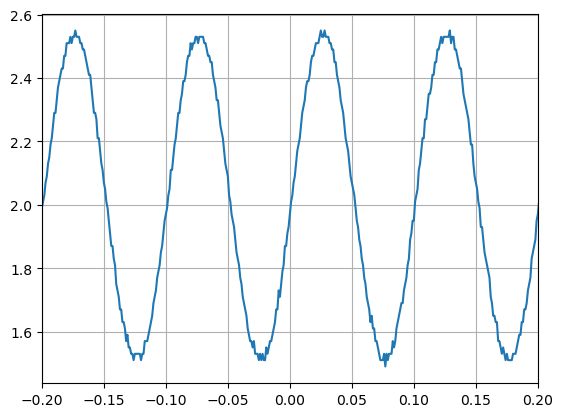

In [57]:
plt.plot(dic[f"{offset}V"]["t_1"],dic[f"{offset}V"]["V_1"])
plt.xlim(-0.2,0.2)
plt.grid()
plt.show()

In [51]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Cuadrada AMP{amp} FREQ{freq} OFFS{offset}.pickle', 'wb'))

# Barrido en amplitud

In [18]:
# Offset de la señal
offset = -2
correccion_posicion = -2*offset
func.write(f"OFFS {offset}")

# Valores de amplitud que tomará la señal
amp_values = np.linspace(0.1,2,20)
# Creamos un diccionario para guardar las mediciones que tomamos
dic = {}

for i, amp in tqdm(enumerate(amp_values)):
    # Cambiamos la amplitud de la señal en voltaje pico a pico
    func.write(f"AMPL {amp} VP")
    print(f"La amplitud cambio a {amp} V")
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(4)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        #for ch in [1,2]:
            #if ch == 1:
        # Cambiamos la escala del canal 1
        #scale = (2*amp/2)-(2*amp/2)%0.005
        #osc.write(f'CH1:SCALE {scale}')
        #osc.write("TRIGGER:MAIN SetLevel")
        # Cambiamos la posición vertical de las señales
        # La posición se selecciona eligiendo los cuadrados del osciloscopio
        #osc.write(f"CH1:POSition {correccion_posicion/scale}")
                
            #else:
              #  scale = 0.05 # 50 mV
        
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el laser funciona con corr < 0
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{amp}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}


0it [00:00, ?it/s]

La amplitud cambio a 0.1 V


1it [00:07,  7.02s/it]

La amplitud cambio a 0.2 V


1it [00:11, 11.03s/it]


NameError: name 'scale' is not defined

In [303]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/Barrido en amplitud a {offset} V de offset.pickle', 'wb'))

# Barrido en offset

In [48]:
func.write(f"OFFS -1")
func.write(f"AMPL 1 VP")
func.write(f"FREQ 1000")
osc.write("TRIGGER:MAIN SetLevel")

23

In [199]:
scale_1 = f'{(2*amp/2)-(2*amp/2)%0.005}'
osc.write(f'CH1:SCALE {scale_1}')
osc.write("TRIGGER:MAIN SetLevel")

23

In [178]:
"En este encontramos que se rompe"
2.9473684210526314 

2.9473684210526314

In [16]:
# Lista con los valores de offset a barrer
offs_values = np.linspace(0, 3.2, 20)


# Amplitud de la señal
amp = 0
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Cambiamos la escala del canal 1
scale_1 = 0.02
osc.write(f'CH1:SCALE {scale_1}')
scale_2 = 0.05
osc.write(f'CH2:SCALE {scale_2}')
# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 5

for i, offset in tqdm(enumerate(offs_values)):
    # Cambiamos el offset de la señal
    func.write(f"OFFS {offset}")
    print(f"El offset cambio a {offset} V")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(t_sleep)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                # Cambiamos la escala del canal 1
                scale = (2*offset/3)-(2*offset/3)%0.005
                osc.write(f'CH{ch}:SCALE {scale}')

            else:
                scale = 0.05 # 50 mV
                    
                # Cambiamos la posición vertical de las señales
                offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
                correccion_posicion = -(offset_anterior-offset_anterior%0.005) 
                # La posición se selecciona eligiendo los cuadrados del osciloscopio
                osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
        
    time.sleep(t_sleep)
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el 
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}


func.write(f"OFFS {offs_values[0]}")

0it [00:00, ?it/s]

El offset cambio a 0.0 V


1it [00:12, 12.97s/it]

Medí positivo
El offset cambio a 0.16842105263157894 V


2it [00:25, 12.99s/it]

El offset cambio a 0.3368421052631579 V


3it [00:38, 12.84s/it]

El offset cambio a 0.5052631578947369 V


4it [00:51, 12.90s/it]

El offset cambio a 0.6736842105263158 V


5it [01:04, 12.94s/it]

El offset cambio a 0.8421052631578947 V


6it [01:17, 12.97s/it]

El offset cambio a 1.0105263157894737 V


7it [01:30, 12.98s/it]

El offset cambio a 1.1789473684210525 V


8it [01:43, 12.99s/it]

El offset cambio a 1.3473684210526315 V


9it [01:56, 13.00s/it]

El offset cambio a 1.5157894736842106 V


10it [02:09, 13.00s/it]

El offset cambio a 1.6842105263157894 V


11it [02:22, 13.00s/it]

El offset cambio a 1.8526315789473684 V


12it [02:35, 13.01s/it]

El offset cambio a 2.0210526315789474 V


13it [02:48, 13.01s/it]

El offset cambio a 2.1894736842105265 V


14it [03:01, 13.03s/it]

El offset cambio a 2.357894736842105 V


15it [03:14, 13.03s/it]

El offset cambio a 2.526315789473684 V


16it [03:27, 13.02s/it]

El offset cambio a 2.694736842105263 V


17it [03:40, 13.01s/it]

El offset cambio a 2.863157894736842 V


18it [03:53, 13.01s/it]

El offset cambio a 3.031578947368421 V


19it [04:06, 13.01s/it]

El offset cambio a 3.2 V


20it [04:19, 12.99s/it]


10

In [17]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Barrido continua a {amp} V de amp sobre R.pickle', 'wb'))

# Barrido en frecuencias

In [21]:
# configuramos una sinusoidal
#func.write("FUNC SIN")
func.write("FUNC 1") # 1 Cuadrada, 0 para el seno
# Seteamos el offset
offset = -3
func.write(f'OFFS {offset}')

# Seteamos la amplitud 
amp = 1
func.write(f'AMPL {amp} VP')

# func.write('OUTE1')

func.write('FREQ 10000')
osc.write(f'HOR:SCA 0.00005')

17

In [6]:
freq_list = np.linspace(100, 15000, 20)
df = freq_list[1]-freq_list[0]

# escalas temporales
t_scales = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]
t_scales.reverse()
j = 0
t_scale = t_scales[j]

# Cambiamos la escala del canal 2
scale_2 = 0.05 # 50mV
osc.write(f'CH2:SCALE {scale_2}')
osc.write("TRIGGER:MAIN SetLevel")

# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 10

for i,freq in tqdm(enumerate(freq_list)):
    
    func.write(f"FREQ {freq}")
    print(f"La frecuencia cambió a {freq}")
    
    # cambiamos la escala temporal
    t = 1/freq # un periodo
    if t < 1.5*t_scale:
        j += 1
        t_scale = t_scales[j]
        osc.write(f'HOR:SCA {t_scale}') # en segundos
        
    if i >= 1:
        # calculamos la amplitud del canal 1
        amp1 = np.max(v_1) - np.min(v_1)
        
        # cambiamos la escala del canal 1
        scale_1 = 0.005 # 5mV
        # Agregamos una corrección para que el canal 1 quede centrado
#         correc_canal = 0.5
        
        # Cambiamos la posicion vertical del canal 1
#         offset_anterior = np.mean(v_1)
#         correccion_posicion = -(offset-offset%0.005) #- correc_canal
#         # La posición se selecciona eligiendo los cuadrados del osciloscopio
#         osc.write(f"CH1:POSition {correccion_posicion/scale_1}")

    time.sleep(t_sleep)
    
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el 
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{freq}Hz"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}

print("\n Terminó el barrido")

0it [00:00, ?it/s]

La frecuencia cambió a 100.0


1it [00:13, 13.13s/it]

La frecuencia cambió a 673.6842105263158


1it [00:23, 23.14s/it]


KeyboardInterrupt: 

In [43]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/Transferencia fotodiodo/Barrido sinusoidal a {amp} V de amp y {offset} V de offset con R=14000 ohm.pickle', 'wb'))

# Barrido con la DAQ

In [5]:
# Para obtener el descriptor de la DAQ
descriptor = ul.get_daq_device_inventory(1)[0] # 7 para ANY o 1 para USB
board_num = ul.get_board_number(descriptor)
print(descriptor)
print(board_num)

[]


In [37]:
# Para iniciar la DAQ
DAQ = ul.create_daq_device(1, descriptor) 

ULError: Error 1027: Specified DAQ device already created.

# Operando con el medidor de potencia

In [10]:
from ThorlabsPM100 import ThorlabsPM100
inst = rm.open_resource("USB0::0x1313::0x8078::P0008162::INSTR", timeout=1)
power_meter = ThorlabsPM100(inst=inst)

# Para leer los datos
print(power_meter.read)
# Para saber la unidad
print(power_meter.getconfigure)

1.3748587e-06
POW


In [27]:
func.write(f"OFFS 0")
func.write(f"AMPL 0 VP")
func.write(f"FREQ 0")

8

In [69]:
POW_ranges = [13e-6,13e-5,13e-4,13e-3,13e-2,13e-1] # Va desde 13 microW hasta 1.3 W

In [70]:
power_meter.sense.power.dc.range.auto = "OFF" # Para apagar el modo automático de determinación del rango

In [14]:
power_meter.sense.power.dc.range.upper = 13e-2

In [25]:
# Lista con los valores de offset a barrer
offs_values = list(np.linspace(0,2.5,20))
# Para empezar desde corrientes altas
#offs_values.reverse()
# Amplitud de la señal
amp = 0
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
scale_1 = 2
# Diccionario para guardar las mediciones
dic = {}
# Saco el modo de rango automatico
power_meter.sense.power.dc.range.auto = "OFF" 
# Definimos la escala inicial del medidor de potencia
POW_range = 13e-4
power_meter.sense.power.dc.range.upper = POW_range
for i, offset in tqdm(enumerate(offs_values)):
    valores_POW = []
    
    print("ESTE ES EL OFFSET", offset)
    # Cambiamos el offset de la señal
    func.write(f"OFFS {offset}")
    #print(f"El offset cambio a {offset} V")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(2)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                scale = scale_1
                # Agregamos una corrección para que el canal 1 quede centrado
                correc_canal = 0.5
            else:
                scale = 0.1 # 100 mV
                # Agregamos una corrección que no afecta al canal 2
                correc_canal = 0
                
            # Cambiamos la posición vertical de las señales
            offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
            correccion_posicion = -(offset_anterior-offset_anterior%0.005) - correc_canal
            # La posición se selecciona eligiendo los cuadrados del osciloscopio
            osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
    
    
    time.sleep(2)
    
    # Medimos la potencia
    for i in range(1000):
        valores_POW.append(power_meter.read)
    
    if np.mean(valores_POW)/POW_range > 0.8: # Nos fijamos si el valor es el tanto % de la escala
        
        # Caso en que vamos aumentando la potencia
        # Aumentamos la escala
        POW_range *= 10
        # La cambiamos en el medidor de potencia
        power_meter.sense.power.dc.range.upper = POW_range
    
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Guardamos los datos
    dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "POW": valores_POW}

0it [00:00, ?it/s]

ESTE ES EL OFFSET 0.0


1it [00:12, 12.05s/it]

ESTE ES EL OFFSET 0.13157894736842105


2it [00:23, 11.77s/it]

ESTE ES EL OFFSET 0.2631578947368421


3it [00:35, 11.78s/it]

ESTE ES EL OFFSET 0.39473684210526316


4it [00:47, 11.73s/it]

ESTE ES EL OFFSET 0.5263157894736842


5it [00:59, 11.84s/it]

ESTE ES EL OFFSET 0.6578947368421052


6it [01:11, 11.91s/it]

ESTE ES EL OFFSET 0.7894736842105263


7it [01:23, 11.91s/it]

ESTE ES EL OFFSET 0.9210526315789473


8it [01:33, 11.46s/it]

ESTE ES EL OFFSET 1.0526315789473684


9it [01:45, 11.67s/it]

ESTE ES EL OFFSET 1.1842105263157894


10it [01:57, 11.68s/it]

ESTE ES EL OFFSET 1.3157894736842104


11it [02:09, 11.74s/it]

ESTE ES EL OFFSET 1.4473684210526314


12it [02:20, 11.63s/it]

ESTE ES EL OFFSET 1.5789473684210527


13it [02:31, 11.53s/it]

ESTE ES EL OFFSET 1.7105263157894737


14it [02:43, 11.47s/it]

ESTE ES EL OFFSET 1.8421052631578947


15it [02:54, 11.38s/it]

ESTE ES EL OFFSET 1.9736842105263157


16it [03:05, 11.42s/it]

ESTE ES EL OFFSET 2.1052631578947367


17it [03:17, 11.39s/it]

ESTE ES EL OFFSET 2.236842105263158


18it [03:28, 11.36s/it]

ESTE ES EL OFFSET 2.3684210526315788


19it [03:39, 11.33s/it]

ESTE ES EL OFFSET 2.5


20it [03:50, 11.55s/it]


In [26]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/Barrido para potencia total 1905.pickle', 'wb'))

# Mediciones de tiempo de respuesta

In [36]:
# Offset de la señal (chequear que sea el que manda -300mA)
offset = -3
func.write(f'OFFS {offset}')

# frecuencia de la cuadrada
freq = 0.5
func.write(f"FREQ {freq}")

amp = 0
func.write(f'AMPL {amp} VP')

#
osc.write(f'HOR:SCA 0.5')
func.write("FUNC 1") 

8

In [ ]:
# Lista con los valores de amplitud a barrer
amp_values = np.linspace(0, 0.5, 10)

# Cambiamos la escala del canal 1
# scale_1 = (2*amp/2)-(2*amp/2)%0.005
# scale_1 = 2
#osc.write(f'CH1:SCALE {scale_1}')
#osc.write("TRIGGER:MAIN SetLevel")

# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 10

for i, amp in tqdm(enumerate(amp_values)):
    print("ESTA ES LA AMPLITUD", amp)
    # Cambiamos la amplitud de la señal
    func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
#     print(f"La amplitud cambio a {amp} Vpp")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(t_sleep)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                scale = scale_1
                # Agregamos una corrección para que el canal 1 quede centrado
                correc_canal = 0.5
            else:
#                 # Cambiamos la escala del canal 2
#                 maximo = max(dic[f"{offs_values[i-1]}V"][f"V_2"])
#                 minimo = min(dic[f"{offs_values[i-1]}V"][f"V_2"])
#                 # Determinamos la amplitud de la cuadrada
#                 amp = maximo-minimo
#                 # Calculamos la escala y la cambiamos
#                 scale = (2*amp/2)-(2*amp/2)%0.005
#                 if scale != 0:
#                     osc.write(f'CH2:SCALE {scale}')
                scale = 0.1 # 50 mV
                # Agregamos una corrección que no afecta al canal 2
                correc_canal = 0
                
                
            # Cambiamos la posición vertical de las señales
            offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
            correccion_posicion = -(offset_anterior-offset_anterior%0.005) - correc_canal
            # La posición se selecciona eligiendo los cuadrados del osciloscopio
            osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
        
    time.sleep(t_sleep)
    # Tomamos mediciones de los canales (canal 1 = fotodiodo, canal 2 = corriente)
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el 
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{amp}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}